In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
import sys  
sys.path.insert(0, '/Users/valerio/Documents/project_IBM_01/IBM_git/lib')
import utilities
from qiskit import IBMQ, execute
from qiskit.providers.aer import QasmSimulator
from sympy import Matrix

N_qubits = 3
t = 1.0
A = np.random.uniform(0,1, size=(2**(N_qubits)-1,2**(N_qubits)-1))
B = np.random.uniform(0,1, size=(2**(N_qubits)-1,2**(N_qubits)-1))

M = A + 1j*B
M = M + np.conjugate(M).T
H = np.zeros((2**N_qubits,2**N_qubits), dtype=complex)
H[1:,1:] = M
H[0,0] = 3.0

U = expm(1j*H*t)


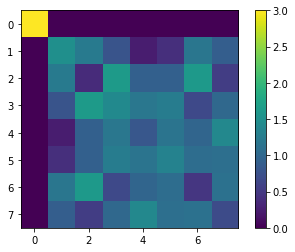

In [2]:
plt.imshow(np.abs(H))
plt.colorbar()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


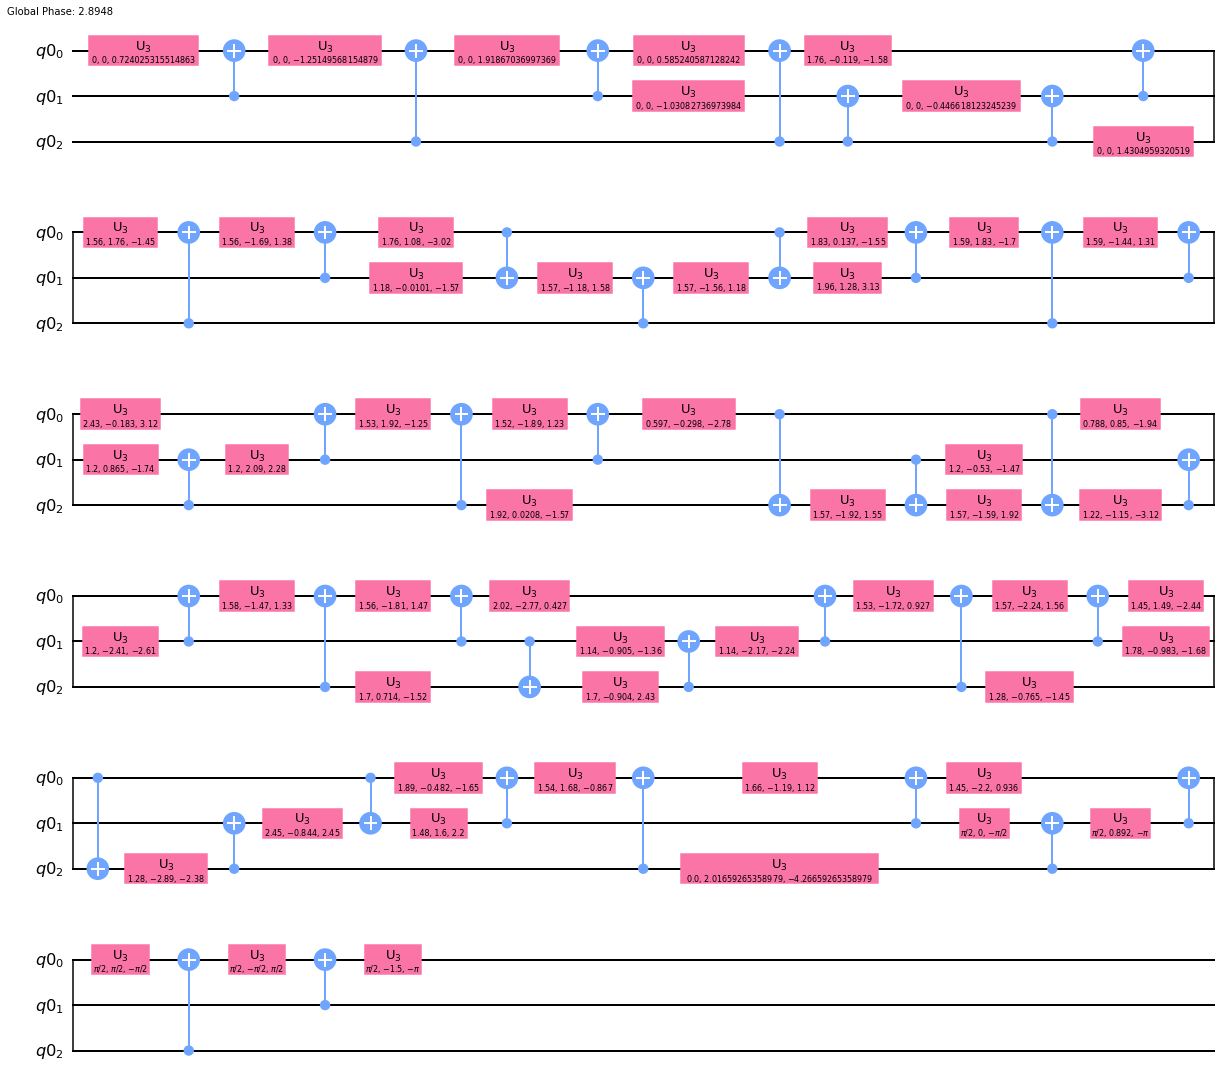

In [3]:
from qiskit import transpile, QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Operator

qr = QuantumRegister(N_qubits)
circ = QuantumCircuit(qr)
circ.unitary(U, qr)
circuit = transpile(circ, basis_gates=["cx", "u3"])
circuit.draw(output="mpl")

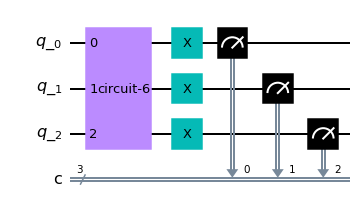

In [4]:
cal_circ, state_labels = utilities.get_calibration_circuits(circuit, method="NIC", eigenvector=N_qubits*"0")
cal_circ[-1].draw(output="mpl")

In [5]:
from qiskit.ignis.verification.tomography import state_tomography_circuits
qr_prep = QuantumRegister(N_qubits)
circuit_prepared = QuantumCircuit(qr_prep)

circuit_prepared.x([qr_prep[1]])
circuit_prepared.append(circuit, qr_prep)

tomo_circuits = state_tomography_circuits(circuit_prepared, qr_prep)

In [6]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')
backend_sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')

#################################################################
########################################### execute all the jobs
BACKEND = backend_sim_noisy_jakarta
shots = 20000
reps = 1 # ATTENZIONE NON PUOI METTEREE PIU DI 1

job_NIC=execute(cal_circ, backend = BACKEND, shots=shots)
job_tomography=execute(tomo_circuits, backend = BACKEND, shots=shots)

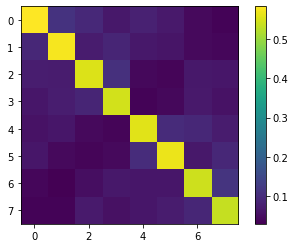

In [7]:
#################################################################
#################################################### Mititgation 
from qiskit.utils.mitigation.fitters import CompleteMeasFitter
import copy
from qiskit.quantum_info import Operator
# building the matrices
meas_fitter_NIC = CompleteMeasFitter(job_NIC.result(), state_labels=state_labels)

# copy the measured probability matrices.
U_tilde_NIC = meas_fitter_NIC.cal_matrix
# defining the tomography basis circuits
qr_basi = QuantumRegister(N_qubits)
qc_basi = QuantumCircuit(qr_basi)
tomography_basis = state_tomography_circuits(qc_basi, qr_basi)
# builds the calibration matrix in the computational basis for NIC methods
C_NIC = U_tilde_NIC
plt.imshow(C_NIC)
plt.colorbar()
plt.show()

[[0.5843  0.1109  0.09325 0.0641  0.07905 0.0667  0.0419  0.03455]
 [0.09115 0.57745 0.0709  0.08585 0.0654  0.06005 0.0424  0.0382 ]
 [0.0728  0.07025 0.5543  0.1054  0.0399  0.03675 0.064   0.062  ]
 [0.06255 0.07395 0.086   0.54735 0.0333  0.0397  0.06645 0.05535]
 [0.0552  0.06285 0.0422  0.03665 0.5603  0.09625 0.0906  0.07165]
 [0.0628  0.04195 0.03635 0.04195 0.09845 0.5685  0.0654  0.08945]
 [0.03815 0.02855 0.04925 0.0647  0.0621  0.0614  0.54095 0.1127 ]
 [0.03305 0.0341  0.06775 0.054   0.0615  0.07065 0.0883  0.5361 ]]


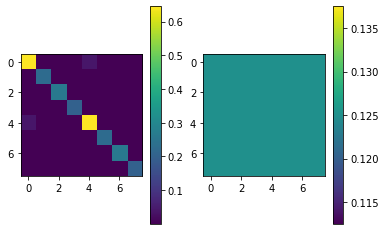

In [11]:

# fast tomography circuits calibration:
# next are computed the calibration matrices in all the tomography basis,
# and after are applyed to the raw result for both CIC and NIC.
meas_fitters_NIC = []
for i, basis in enumerate(tomography_basis):
    basis.remove_final_measurements()
    # building the unitary matrix of the basis and the inverse.
    base_matrix_amplitudes = Operator(basis)
    base_matrix_amplitudes_inverse = base_matrix_amplitudes.transpose().conjugate()
    # building the probability matrices.
    base_matrix = np.abs(base_matrix_amplitudes)**2
    base_matrix_inverse = np.abs(base_matrix_amplitudes_inverse)**2

    C_basis_NIC = np.abs(np.linalg.multi_dot([base_matrix_amplitudes, C_NIC,  base_matrix_amplitudes_inverse]))**2
    #C_basis_NIC = np.linalg.multi_dot([base_matrix, C_NIC,  base_matrix_inverse])
    #C_basis_NIC = np.abs(np.dot(base_matrix_amplitudes, C_NIC))**2
    # changing the meas_fitter_SSD_NIC calibration matrix with the new calibration matrix. 
    meas_fitter_NIC_aus = copy.deepcopy(meas_fitter_NIC)
    meas_fitter_NIC_aus._tens_fitt.cal_matrices[0]=C_basis_NIC
    meas_fitters_NIC.append(meas_fitter_NIC_aus)

    if i==1:
        plt.subplot(121)
        plt.imshow(meas_fitters_NIC[i].cal_matrix)
        plt.colorbar()

        plt.subplot(122)
        plt.imshow(base_matrix)
        plt.colorbar()

        print(C_NIC)

plt.show()


In [12]:

################################### mitigates the raw results
raw_result = [] #jobs_tomo_SSD[rep].result()
NIC_result = [] #copy.deepcopy(raw_result_SSD)
for rep in range(reps):
    #raw_result_SSD.append(jobs_tomography[rep].result())
    raw_result.append(job_tomography.result())
    NIC_result.append(copy.deepcopy(raw_result[rep]))
    for i in range(3**N_qubits):
        # computing the new counts for both the mitigation techniques
        old_counts=raw_result[rep].get_counts(i)
        new_counts_NIC = meas_fitters_NIC[i].filter.apply(old_counts, method="least_squares")
        NIC_result[rep].results[i].data.counts = new_counts_NIC

In [13]:
from qiskit.opflow import One, Zero

# defining the target_state = |110> ; qubits: |5,3,1>
# target_state = (One^One^Zero).to_matrix()
target_state = U[:,2]
# compute the fidelity for each repetition
fids_SSD = {"raw": np.zeros(reps), "NIC": np.zeros(reps), "CIC": np.zeros(reps)}
for rep in range(reps):
    fids_SSD["raw"][rep] = utilities.fidelity_count(raw_result[rep], tomo_circuits, target_state)
    fids_SSD["NIC"][rep] = utilities.fidelity_count(NIC_result[rep], tomo_circuits, target_state)
# computes the mean and the standard deviation
fid_means = {"raw": np.mean(fids_SSD["raw"]), "NIC": np.mean(fids_SSD["NIC"])}
fid_std = {"raw": np.std(fids_SSD["raw"]), "NIC": np.std(fids_SSD["NIC"])}

# fidelity
text2 = "fidelity of raw results: %.5f +- %.5f \n"%(fid_means["raw"],fid_std["raw"])
text2 = text2 + "fidelity with NIC method: %.5f +- %.5f \n" %(fid_means["NIC"],fid_std["NIC"])

print(text2)

fidelity of raw results: 0.46329 +- 0.00000 
fidelity with NIC method: 0.88387 +- 0.00000 

